<a href="https://colab.research.google.com/github/maryvorob/mary/blob/master/uchi_product_analyst_t_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np, pandas as pd, seaborn as sns
from pprint import pprint
from scipy.stats import norm
plt.style.use('fivethirtyeight')


def download_files(path='https://raw.githubusercontent.com/maryvorob/mary/master/',
                   files=('checks', 'groups', 'active_studs')):
    data = []
    for f in files:
        df = pd.read_csv(f'{path}/{f}.csv', sep=';') 
        display(f, df.head(3))
        data.append(df)
    return data

checks, groups, active_studs = download_files()

'checks'

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


'groups'

,id,grp
0,1206794,B
1,331024,B
2,1733498,A


'active_studs'

,student_id
0,581585
1,5723133
2,3276743


rev
users active orders             
1     0.0    0.0          0.0000
             1.0     105532.0001
      1.0    0.0          0.0000
             1.0     467794.0035

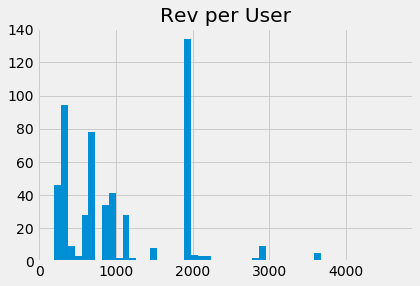

In [2]:
def join_data(checks, groups, active_studs):
    data = groups.set_index('id').join(active_studs['student_id'].value_counts().rename('active'))
    data = data.join(checks.groupby('student_id')['rev'].agg(orders='count', rev='sum'))
    return data.fillna(0)

data = join_data(checks, groups, active_studs)
data['users'] = 1
display(data.groupby([data['users'], data['active'], data['orders']]).sum())
plt.hist(data[data['rev'] > 0]['rev'], bins=50)
plt.title('Rev per User');



# Some inactive students have orders and revenue, which is not intuitive.

# T-test

(относительные метрики = test / control - 1, в скобках приведены 90% интервалы)

* Статистически значимое увеличение количества __активных пользователей +8.5% (4% to 13%)__
* Статистически значимое увеличение __среднего чека +29% (12% to 45%)__
* Статистически значимое увеличение __средней выручки на пользователя +28% (3% to 53%)__
* Не значимое уменьшение конверсии

In [3]:
def _fmt(arr, fmt):
    return np.array2string(arr, formatter={'float_kind': lambda x: f'{x:{fmt}}'})


def _print(conf, pval, t, c, ci, fmt):
    print(f'P val: {pval:.3f}, P ctrl: {c:{fmt}}, P test: {t:{fmt}}')
    print(f'Abs diff, [{conf:.0%} interval]: {t - c:{fmt}}, {_fmt(ci, fmt)}') 
    print(f'Rel diff, [{conf:.0%} interval]: {t / c - 1:.2%}, {_fmt((c + ci) / c - 1, ".2%")}') 
    return 


def _test(delta, se, alpha):
    z = delta / se
    pval = norm.sf(np.abs(z)) * 2
    ci = delta + se * norm.ppf([alpha / 2, 1 - alpha / 2])
    return z, pval, ci


def prop_test(xt, xc, nt, nc, conf):
    pt, pc = xt / nt, xc / nc
    p = (xt + xc) / (nt + nc)
    se = np.sqrt(p * (1 - p) * (1 / nt + 1 / nc))
    z, pval, ci = _test(pt - pc, se, 1 - conf)
    _print(conf, pval, pt, pc, ci, '.2%')
    return pval


def mean_test(mt, mc, st, sc, nt, nc, conf):
    se = np.sqrt(st ** 2 / nt + sc ** 2 / nc)
    z, pval, ci = _test(mt - mc, se, 1 - conf)
    _print(conf, pval, mt, mc, ci, '.2f')
    return pval

def run_tests(prop_metrics, mean_metrics, data, conf):
    for k, (x, n) in prop_metrics.items():
        print('\n', ' -' * 10, k, '- ' * 10)
        df = data[data[n] > 0].groupby(['grp']).agg(['sum', 'std', 'mean'])
        t, c = df.loc['B'], df.loc['A']
        prop_test(t[(x, 'sum')], c[(x, 'sum')], t[(n, 'sum')], c[(n, 'sum')], conf)
    for k, (x, n) in mean_metrics.items():
        print('\n', ' -' * 10, k, '- ' * 10)
        df = data[data[n] > 0].groupby(['grp']).agg(['sum', 'std', 'mean'])
        t, c = df.loc['B'], df.loc['A']
        mean_test(t[(x, 'mean')], c[(x, 'mean')], t[(x, 'std')], c[(x, 'std')], t[(n, 'sum')], c[(n, 'sum')], conf)


prop_metrics = {'active_pct': ['active', 'users'], 'cvr': ['orders', 'active']}
mean_metrics = {'aov': ['rev', 'orders'], 'arpu': ['rev', 'users']}

run_tests(prop_metrics, mean_metrics, data, conf=0.9)


  - - - - - - - - - - active_pct - - - - - - - - - - 
P val: 0.002, P ctrl: 10.47%, P test: 11.36%
Abs diff, [90% interval]: 0.89%, [0.42% 1.37%]
Rel diff, [90% interval]: 8.53%, [3.97% 13.09%]

  - - - - - - - - - - cvr - - - - - - - - - - 
P val: 0.445, P ctrl: 5.07%, P test: 4.62%
Abs diff, [90% interval]: -0.46%, [-1.44% 0.53%]
Rel diff, [90% interval]: -8.99%, [-28.37% 10.39%]

  - - - - - - - - - - aov - - - - - - - - - - 
P val: 0.004, P ctrl: 860.71, P test: 1108.82
Abs diff, [90% interval]: 248.11, [105.77 390.46]
Rel diff, [90% interval]: 28.83%, [12.29% 45.37%]

  - - - - - - - - - - arpu - - - - - - - - - - 
P val: 0.063, P ctrl: 6.27, P test: 8.04
Abs diff, [90% interval]: 1.77, [0.20 3.33]
Rel diff, [90% interval]: 28.21%, [3.24% 53.18%]


# Bootstrap

Из-за небольшого количества данных, метрики незначительно отличаются от t-testов.<br>
На больших данных методы должны показывать одинаковые результаты.

,0.05,0.5,0.95
active_pct,+3.94%,+8.53%,+13.31%
cvr,-22.56%,-8.25%,+9.73%
aov,+10.15%,+29.34%,+52.25%
arpu,+2.85%,+28.82%,+64.03%


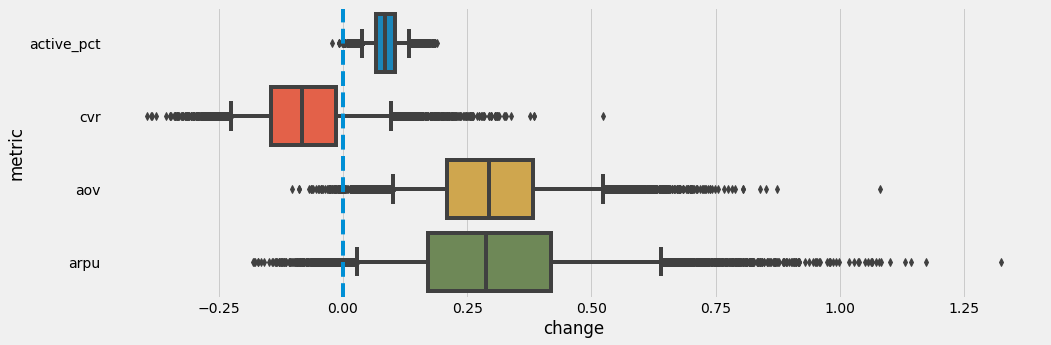

In [4]:
def bootstrap(data, n_bootstraps=10000, n_segments=1000):
    data = data.copy()
    data['segment_id'] = list(map(lambda x: hash(str(x)) % n_segments, data.index))
    df = data.groupby(['segment_id', 'grp']).sum().unstack('grp')
    df.columns = df.columns.map('_'.join)
    bt = df.sample(n_bootstraps * n_segments, replace=True)
    bt['bootstrap_id'] = list(range(n_bootstraps)) * n_segments
    stats = bt.groupby('bootstrap_id').sum()
    return stats 


def box(df, low, high):
    data=df.stack().reset_index(1).rename(columns={0: 'change', 'level_1': 'metric'})
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    sns.boxplot('change', 'metric', data=data, whis=[low * 100, high * 100])
    ax.axvline(0, ls='--')


def analyse(stats, low=0.05, high=0.95, test='B', control='A'):
    df = stats.copy()
    for g in (test, control):
        df[f'active_pct_{g}'] = df[f'active_{g}'] / df[f'users_{g}'] # Convertion from Active to Order
        df[f'cvr_{g}'] = df[f'orders_{g}'] / df[f'active_{g}'] # Convertion from Active to Order
        df[f'aov_{g}'] = df[f'rev_{g}'] / df[f'orders_{g}'] # Average Order Value
        df[f'arpu_{g}'] = df[f'rev_{g}'] / df[f'users_{g}'] # Average Reveue per User

    metrics = ['active_pct', 'cvr', 'aov', 'arpu']
    for metric in metrics:
        df[metric] = df[f'{metric}_{test}'] / df[f'{metric}_{control}'] - 1 # Relative difference Test vs Control
    
    box(df[metrics], low, high)
    summary = df[metrics].quantile([low, 0.5, high]).T
    return summary
    

stats = bootstrap(data) 
summary = analyse(stats)
summary.style.format('{:+.2%}')